In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from tqdm import tqdm
from glob import glob
import pwlf

In [2]:
plt.rc('ps', useafm=True)
plt.rc('pdf', use14corefonts=True)

In [3]:
data_dir = '/home/shivar/Research/traffic/traffic_jams/data/'

In [4]:
wayids = []
wayids += [97684961, 231493253] # low
wayids += [436796431, 97887865, 364028123, 97868341, 924017330, 
          924017328, 678089206, 678097778, 364028158, 364028159, 
          920601761, 920601759, 678072376, 97862870, 231493261, 
          387721418, 924027935, 679747475, 676955524, 676955525, 
          676955526, 364028151, 97862895, 364028148, 364028126, 
          923641683, 923641682, 923641681, 679747457, 679756075, 
          161487256, 231493248] # medium
wayids += [471508538, 679837859, 680050186, 679837860] # high

1 38 97684961


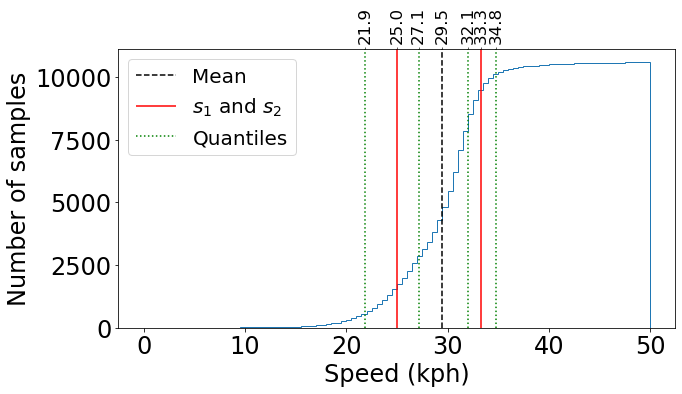

In [5]:
# defining the s1 and s2 breakpoints using quantiles or arbitrary fractions 
# such as 2/3rd or half does not make a lot of sense, because there is no 
# justification for such choices. A principled approach would be to do a 
# 3-way piecewise linear regression and obtain the breakpoints s1 and s2.

plt.rc('font', size=24)

for ind, wayid in enumerate(wayids, 1):
    print(ind, len(wayids), wayid)
    fpath = data_dir + 'per-segment/{}.csv'.format(wayid)
    if not os.path.exists(fpath):
        continue
    series = np.loadtxt(fpath, delimiter=',', dtype=float, skiprows=1, usecols=[2])
    if series.ndim == 0 or len(series) == 0:
        continue
    series_ma = np.ma.masked_invalid(series)
    series.sort()
    
    # scale the max to 50 kph
    min_speed, max_speed = series_ma.min(), series_ma.max()
    series_scaled_ma = (series_ma - min_speed) * 50.0 / (max_speed - min_speed)
    
    mean = series_scaled_ma.mean()
    quantiles = np.quantile(series_scaled_ma, [0.05, 0.25, 0.75, 0.95])
    s1, s2 = series_scaled_ma.max() * 2/3, series_scaled_ma.max() / 2
    
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    # ax.plot(series[::-1])
    ax.hist(series_scaled_ma, bins=100, cumulative=True, histtype='step')
    ymin, ymax = ax.get_ylim()
    ax.axvline(mean, c='k', ls='--', label='Mean')
    ax.vlines([s1, s2], ymin, ymax, colors='r', linestyles='-', label=r'$s_1$ and $s_2$')
    ax.vlines(quantiles, ymin, ymax, colors='g', linestyles=':', label='Quantiles')
    ax.set_ylim(ymin, ymax)
    stats = [mean, s1, s2] + quantiles.tolist()
    ax.set_xticks(stats, ['{:.1f}'.format(val) for val in stats], minor=True)
    ax.tick_params(which='minor', axis='x', bottom=0, top=1, labelbottom=0, labeltop=1, labelrotation=90, labelsize='x-small')
    ax.set_xlabel('Speed (kph)')
    ax.set_ylabel('Number of samples')
    ax.legend(loc='upper left', fontsize='small')
    fig.tight_layout()
    #fig.subplots_adjust(left=0.12, right=0.92, bottom=0.08, top=0.98)
    #fig.savefig('../figures/speed_plots/{}.png'.format(wayid))
    #fig.savefig('../figures/speed_plots/{}.pdf'.format(wayid))
    plt.show()
    plt.close(fig)
    break

13923
[ 9.89664062 30.28419941 42.00484797 68.43348438]
9.601 68.729125
0.9973135637033271


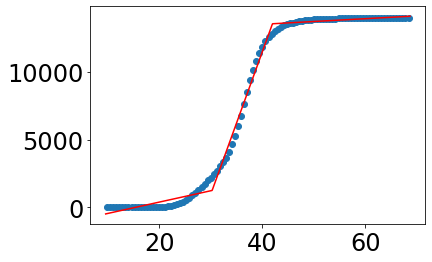

In [22]:
# piece wise regression

# def piecewise_func(x, x0, x1, a1, a2, a3, b):
#     condlist = [x < x0, (x >= x0) & (x < x1), x >= x1]
#     funclist = [lambda x: a1*x + b, lambda x: a2*x + (a1-a2)*x0 + b, lambda x: a3*x + (a2-a3)*x1 + (a1-a2)*x0 + b]
#     return np.piecewise(x, condlist, funclist)

#wayid = 4742016
#wayid = 471508538
wayid = 4716860
series = np.loadtxt(data_dir + 'per-segment/{}.csv'.format(wayid), delimiter=',', dtype=float, skiprows=1, usecols=[2])
series_ma = np.ma.masked_invalid(series)
print(series_ma.count())
hist, bin_edges = np.histogram(series_ma, bins=100)
cdf = np.cumsum(hist)
bin_midpts = (bin_edges[1:] + bin_edges[:-1]) / 2
#p, e = optimize.curve_fit(piecewise_func, bin_midpts, cdf, p0=[30, 40, 0.1, 10, 0.1, 0])
#print(p)
pwlf_func = pwlf.PiecewiseLinFit(bin_midpts, cdf)
breaks = pwlf_func.fitfast(3)
print(breaks)
print(series_ma.min(), series_ma.max())
print(pwlf_func.r_squared())
xp = np.linspace(bin_edges[0], bin_edges[-1], 1000)
#yp = piecewise_func(xp, *p)
yp = pwlf_func.predict(xp)
plt.plot(bin_midpts, cdf, 'o')
plt.plot(xp, yp, c='r')

In [10]:
# we need some rationale for selecting segments
# - so select only segments which have at least one data point for every hour
flist = glob(data_dir + 'per-segment/*.csv')

wayids_select = []
wayids_discard = []

for fpath in tqdm(flist):
    wayid = os.path.basename(fpath)[:-4]
    df = pd.read_csv(fpath, usecols=[1,2], index_col=0, parse_dates=True)
    n_total = df.speed_kph_mean.count()
    df['hour'] = df.index.hour
    hour_counts = df.groupby('hour').count()
    if hour_counts.size == 24:
        wayids_select.append((wayid, n_total))
    else:
        wayids_discard.append((wayid, n_total, hour_counts.size))

100%|██████████| 4817/4817 [01:35<00:00, 50.21it/s] 


In [11]:
print('To select:', len(wayids_select))
print('To discard:', len(wayids_discard))
wayids_select = pd.DataFrame(wayids_select, columns=['wayid', 'num_samples']).set_index('wayid')
wayids_select.sort_values('num_samples', inplace=True, ascending=False)
wayids_discard = pd.DataFrame(wayids_discard, columns=['wayid', 'num_samples', 'num_hours_avail']).set_index('wayid')
wayids_discard.sort_values('num_samples', inplace=True, ascending=False)

To select: 2005
To discard: 2812


In [14]:
wayids_select.to_csv('wayids_all_hours_avail.csv')
wayids_select

,num_samples
wayid,
344476914,17385
337522391,17378
4723986,17378
4730089,17377
344477408,17375
...,...
76967085,377
26468883,324
680875540,283


In [15]:
wayids_discard.to_csv('wayids_not_all_hours_avail.csv')
wayids_discard

,num_samples,num_hours_avail
wayid,,
619161875,10389,23
40131530,9848,23
204553720,9702,22
675672889,9671,23
24009460,9577,23
...,...,...
262775038,1,1
380161572,1,1
678137698,1,1


In [16]:
(wayids_discard.num_hours_avail >= 18).sum()

898

In [89]:
import warnings
warnings.filterwarnings("ignore")

plt.rc('font', size=24)

fout = open('speed_cdf_stats_select_4.csv', 'w')
fout.write('wayid,num_samples,min_speed,s1,s2,max_speed,s1_cumfrac,s2_cumfrac,r_squared,s2_s1_cumfrac_diff' + os.linesep)

#flist = glob(data_dir + 'per-segment/*.csv')
#for fpath in tqdm(flist):

# instead of iterating through all the segments, only iterate through the 2903 segments
# in which data is available for at least 18 hours in a day across all of the 2 year 
# time period. Any segment for which data is available for less than 18 hours in a day 
# are discarded.

#list1 = wayids_select.index
#list2 = wayids_discard.index[wayids_discard.num_hours_avail >= 18]

#print('Total number of segments to process:', len(list1) + len(list2))

from itertools import chain

#for wayid in tqdm(chain(list1, list2), total=len(list1) + len(list2)):
#for wayid in tqdm(wayids_mismatch):
for wayid in tqdm([678331193]):
    # wayid = os.path.basename(fpath)[:-4]
    series = np.loadtxt(data_dir + 'per-segment/{}.csv'.format(wayid), 
                        delimiter=',', dtype=float, skiprows=1, usecols=[2])
    if series.ndim == 0 or len(series) == 0:
        continue
    series_ma = np.ma.masked_invalid(series)
    
    hist, bin_edges = np.histogram(series_ma, bins=100)
    Y = np.cumsum(hist)
    X = (bin_edges[:-1] + bin_edges[1:]) / 2
    pwlfunc = pwlf.PiecewiseLinFit(X, Y)
    breaks = pwlfunc.fit(3)
    s1, s2 = breaks[1], breaks[2]
    
    num_samples = series_ma.count()
    max_speed, min_speed = series_ma.max(), series_ma.min()
    s1_cumfrac, s2_cumfrac = pwlfunc.predict([s1, s2]) / num_samples

    fout.write('{},{},{:.1f},{:.1f},{:.1f},{:.1f},{:.4f},{:.4f},{:.3f},{:.4f}'.format(wayid, num_samples, min_speed, s1, s2, max_speed, s1_cumfrac, s2_cumfrac, pwlfunc.r_squared(), s2_cumfrac - s1_cumfrac) + os.linesep)
    
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.plot(X, Y, 'o')
    xp = np.linspace(X[0], X[-1], 1000)
    yp = pwlfunc.predict(xp)
    ax.plot(xp, yp, c='r')
    ax.set_xlabel('Speed (kph)')
    ax.set_ylabel('Number of samples')
    ax.axvline(s1, c='k', ls=':', label=r'$s_1 = {:.1f}$'.format(s1))
    ax.axvline(s2, c='k', ls=':', label=r'$s_2 = {:.1f}$'.format(s2))
    ax.set_xticks([s1, s2], ['s1', 's2'], minor=True)
    ax.tick_params(which='minor', axis='x', bottom=0, top=1, labelbottom=0, labeltop=1)
    ax.legend(loc=0, fontsize='small')
    fig.tight_layout()
    fig.savefig('../figures/speed_plots/{}.pdf'.format(wayid))
    plt.close(fig)

fout.close()

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


In [56]:
# repeat fits for those segments for which the fit didn't happen properly
table1 = pd.read_csv('speed_cdf_stats_select.csv', index_col=0).drop(['min', 'max'], axis=1)
table2 = pd.read_csv('speed_cdf_stats_select_2.csv', index_col=0).drop('num_samples', axis=1)
table = table1.join(table2, lsuffix='_1', rsuffix='_2')
table

,num_samples,s1_1,s2_1,r_squared_1,min_speed,s1_2,s2_2,max_speed,s1_cumfrac,s2_cumfrac,r_squared_2
wayid,,,,,,,,,,,
344476914,17385,18.1,37.1,0.995,12.3,18.1,37.1,60.9,0.0013,0.9535,0.995
337522391,17378,50.8,87.0,0.998,6.5,50.8,87.0,104.3,0.1438,0.9956,0.998
4723986,17378,57.3,76.1,0.998,10.1,57.3,76.1,93.4,0.0581,0.9494,0.998
4730089,17377,21.0,41.2,0.998,17.0,21.0,41.2,71.8,0.0057,0.9577,0.998
344477408,17375,20.1,45.6,0.998,16.6,20.1,45.6,81.0,0.0070,0.9672,0.998
...,...,...,...,...,...,...,...,...,...,...,...
678119021,45,36.4,44.5,0.997,15.3,36.4,44.5,51.0,0.1623,0.8133,0.997
501395792,44,20.7,23.6,0.998,16.1,20.7,23.6,27.5,0.3256,0.8933,0.998
680549029,39,22.0,29.9,0.990,16.1,22.0,29.9,51.2,0.1247,0.7679,0.990


In [57]:
# there should be some separation between s1_cumfrac and s2_cumfrac
table['s2_s1_cumfrac_diff'] = table.s2_cumfrac.values - table.s1_cumfrac.values
table.sort_values('s2_s1_cumfrac_diff', inplace=True)
table

,num_samples,s1_1,s2_1,r_squared_1,min_speed,s1_2,s2_2,max_speed,s1_cumfrac,s2_cumfrac,r_squared_2,s2_s1_cumfrac_diff
wayid,,,,,,,,,,,,
419291437,105,40.4,48.6,0.998,17.8,40.4,48.6,53.5,0.8953,0.9893,0.998,0.0940
26787907,404,16.0,24.2,0.997,6.5,16.0,24.2,54.5,0.8872,0.9816,0.997,0.0944
680342277,1162,6.0,28.4,0.999,2.9,27.1,35.1,54.0,0.8908,0.9860,0.998,0.0952
239805680,5395,28.2,37.3,0.998,1.8,28.2,37.3,65.0,0.8847,0.9885,0.998,0.1038
24716397,889,40.8,54.2,0.999,5.2,40.8,54.2,82.8,0.8554,0.9748,0.999,0.1194
...,...,...,...,...,...,...,...,...,...,...,...,...
311725584,15363,10.4,35.4,0.997,2.2,10.4,35.4,62.7,0.0043,0.9893,0.997,0.9850
698498913,16476,15.5,57.2,0.997,8.0,15.5,57.2,81.1,0.0012,0.9866,0.997,0.9854
4962801,17353,20.0,56.8,0.996,8.4,20.0,56.8,77.5,0.0082,0.9962,0.996,0.9880


In [58]:
table.loc[((table.s2_2 - table.s2_1) != 0) & ((table.s1_2 - table.s1_1) != 0)]

,num_samples,s1_1,s2_1,r_squared_1,min_speed,s1_2,s2_2,max_speed,s1_cumfrac,s2_cumfrac,r_squared_2,s2_s1_cumfrac_diff
wayid,,,,,,,,,,,,
680342277,1162,6.0,28.4,0.999,2.9,27.1,35.1,54.0,0.8908,0.9860,0.998,0.0952
675471709,683,6.2,9.7,0.994,5.2,9.3,12.1,50.4,0.8699,0.9913,0.993,0.1214
128126803,224,13.6,25.1,0.996,5.7,13.4,24.4,68.1,0.8392,0.9921,0.996,0.1529
678331193,54,7.6,16.9,0.990,5.0,16.4,27.3,47.7,0.8021,0.9573,0.990,0.1552
680878532,3660,10.5,27.3,0.992,5.8,25.6,38.3,85.1,0.8256,0.9893,0.992,0.1637
670423540,16313,12.1,19.4,0.997,1.2,12.0,19.0,69.3,0.8200,0.9906,0.997,0.1706
440744015,125,25.5,33.5,0.992,16.3,18.7,25.9,45.3,0.0603,0.8831,0.992,0.8228
667463174,184,24.9,37.9,0.993,1.0,7.0,28.7,78.0,0.0489,0.8857,0.993,0.8368
24968896,279,24.7,39.5,0.992,10.3,14.0,25.2,70.3,0.0324,0.8742,0.992,0.8418


In [53]:
wayids_mismatch = table.loc[((table.s2_2 - table.s2_1) != 0) & ((table.s1_2 - table.s1_1) != 0)].index

In [59]:
table_mismatch = pd.read_csv('speed_cdf_stats_select_mismatch.csv', index_col=0)
table_mismatch['s2_s1_cumfrac_diff'] = table_mismatch.s2_cumfrac.values - table_mismatch.s1_cumfrac.values
table_mismatch.sort_values('s2_s1_cumfrac_diff', inplace=True)
table_mismatch

,num_samples,min_speed,s1,s2,max_speed,s1_cumfrac,s2_cumfrac,r_squared,s2_s1_cumfrac_diff
wayid,,,,,,,,,
128126803,224,5.7,13.6,25.1,68.1,0.8533,0.9930,0.996,0.1397
678331193,54,5.0,16.4,27.3,47.7,0.8021,0.9573,0.990,0.1552
24968896,279,10.3,24.7,39.5,70.3,0.8016,0.9629,0.992,0.1613
670423540,16313,1.2,12.1,19.4,69.3,0.8255,0.9918,0.997,0.1663
667463174,184,1.0,24.9,37.9,78.0,0.7392,0.9429,0.993,0.2037
440744015,125,16.3,18.7,25.9,45.3,0.0603,0.8831,0.992,0.8228
659308906,12021,5.2,23.1,35.0,76.0,0.0719,0.9453,0.997,0.8734
40006022,3649,3.9,8.6,25.4,72.9,0.0191,0.8968,0.992,0.8777
369093061,11253,3.0,40.9,52.2,86.5,0.0345,0.9205,0.998,0.8860


In [71]:
table_mismatch_prior = table.loc[wayids_mismatch]
table_mismatch_prior.sort_index(inplace=True)
table_mismatch.sort_index(inplace=True)
table_mismatch_compare = table_mismatch_prior[['s1_1', 's2_1', 's1_2', 's2_2', 's2_s1_cumfrac_diff']]
table_mismatch_compare['s1_3'] = table_mismatch['s1'].values
table_mismatch_compare['s2_3'] = table_mismatch['s2'].values
table_mismatch_compare['s2_s1_cumfrac_diff_3'] = table_mismatch['s2_s1_cumfrac_diff'].values
table_mismatch_compare['diff_3_diff_2'] = np.abs((table_mismatch_compare.s2_s1_cumfrac_diff_3 - table_mismatch_compare.s2_s1_cumfrac_diff).values)
table_mismatch_compare.sort_values('diff_3_diff_2', inplace=True)
print(table_mismatch_compare.shape[0])
table_mismatch_compare

22


,s1_1,s2_1,s1_2,s2_2,s2_s1_cumfrac_diff,s1_3,s2_3,s2_s1_cumfrac_diff_3,diff_3_diff_2
wayid,,,,,,,,,
440744015,25.5,33.5,18.7,25.9,0.8228,18.7,25.9,0.8228,0.0000
659308906,23.4,34.9,23.1,35.0,0.8734,23.1,35.0,0.8734,0.0000
564775723,10.4,24.2,10.1,24.5,0.8956,10.1,24.5,0.8956,0.0000
680032417,22.8,33.5,6.6,24.6,0.9066,6.6,24.6,0.9066,0.0000
671416854,20.4,30.8,6.3,22.1,0.9187,6.3,22.1,0.9187,0.0000
332240217,39.4,47.8,13.8,50.8,0.9752,13.8,50.8,0.9752,0.0000
40478814,11.7,33.8,11.6,34.0,0.9474,11.6,34.0,0.9474,0.0000
40006022,23.8,37.7,8.6,25.4,0.8777,8.6,25.4,0.8777,0.0000
27014344,23.0,34.6,4.9,23.8,0.9256,4.9,23.8,0.9256,0.0000


In [70]:
# if diff_3_diff_2 is zero (or close to 0 AND diff_3 is higher), and cumfrac_diff > 0.8, 
# then we're good. Just replace the old figures in the wayids_goodfit folder 
# with the new figures
# the correct results for these are speed_cdf_stats_select_mismatch.csv
wayids_mismatch_good = table_mismatch_compare.index[(table_mismatch_compare.diff_3_diff_2 == 0) & (table_mismatch_compare.s2_s1_cumfrac_diff > 0.8)]
# also - 369093061, 231511119, 260916930 - from the above table visually

wayids_mismatch_good = wayids_mismatch_good.to_list() + [369093061, 231511119, 260916930]

for wayid in wayids_mismatch_good:
    #os.rename('../figures/speed_plots/{}.pdf'.format(wayid), '../figures/speed_plots/wayids_goodfit/{}_refit.pdf'.format(wayid))
    pass

print(wayids_mismatch_good)
print(len(wayids_mismatch_good))

[440744015, 659308906, 564775723, 680032417, 671416854, 332240217, 40478814, 40006022, 27014344, 25858120, 369093061, 231511119, 260916930]
13


In [68]:
# else if second batch is correct, then we'll need to re-run for the correct figures (optional)
# the correct results are in speed_cdf_stats_select_2.csv
wayids_mismatch_need_rerun_for_figures = [529987011, 667463174, 24968896]

In [72]:
# correct results are in speed_cdf_stats_select_mismatch.csv
wayids_mismatch_correct_3 = [680878532, 680342277, 675471709]

In [73]:
# else if first batch is correct, then we'll need to re-run for cumfrac values
wayids_mismatch_need_rerun_for_values = [678331193]

In [76]:
# else just simply discard because they're bad fit
wayids_mismatch_discard = [670423540, 128126803]

In [82]:
table2 = pd.read_csv('speed_cdf_stats_select_2.csv', index_col=0)
table_final = pd.DataFrame(index=table.index, columns=table_mismatch.columns)
table_final.drop(wayids_mismatch_discard, axis=0, inplace=True)

for wayid in tqdm(table.index):
    if not wayid in table_mismatch.index:
        # correct entry is in speed_cdf_stats_select_2.csv
        table_final.loc[wayid] = table2.loc[wayid]
        table_final.loc[wayid, 's2_s1_cumfrac_diff'] = table_final.loc[wayid, 's2_cumfrac'] - table_final.loc[wayid, 's1_cumfrac']
    else:
        if wayid in wayids_mismatch_need_rerun_for_figures:
            # correct entry is in speed_cdf_stats_select_2.csv
            table_final.loc[wayid] = table2.loc[wayid]
            table_final.loc[wayid, 's2_s1_cumfrac_diff'] = table_final.loc[wayid, 's2_cumfrac'] - table_final.loc[wayid, 's1_cumfrac']
        elif wayid in wayids_mismatch_good or wayid in wayids_mismatch_correct_3:
            # correct entry is in speed_cdf_stats_select_mismatch.csv
            table_final.loc[wayid] = table_mismatch.loc[wayid]
        elif wayid in wayids_mismatch_need_rerun_for_values:
            # correct entry is in speed_cdf_stats_select.csv (first run), but column names 
            # have changed, and cumfrac values are unavailable for now
            table_final.loc[wayid, 'num_samples'] = table1.loc[wayid].num_samples
            table_final.loc[wayid, 'min_speed'] = table2.loc[wayid].min_speed
            table_final.loc[wayid, 's1'] = table1.loc[wayid].s1
            table_final.loc[wayid, 's2'] = table1.loc[wayid].s2
            table_final.loc[wayid, 'max_speed'] = table2.loc[wayid].max_speed
            table_final.loc[wayid, 'r_squared'] = table1.loc[wayid].r_squared

100%|██████████| 2903/2903 [00:01<00:00, 1631.05it/s]


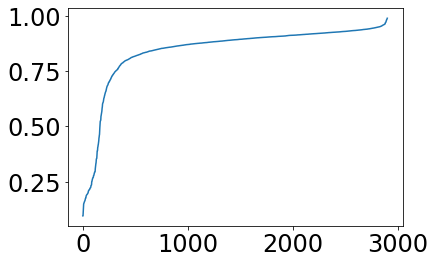

In [84]:
table_final.sort_values('s2_s1_cumfrac_diff', inplace=True)
plt.plot(table_final.s2_s1_cumfrac_diff.values)

In [85]:
table_final.loc[table_final.s2_s1_cumfrac_diff > 0.75]

,num_samples,min_speed,s1,s2,max_speed,s1_cumfrac,s2_cumfrac,r_squared,s2_s1_cumfrac_diff
wayid,,,,,,,,,
640073514,11524.0,0.6,13.8,30.1,63.7,0.2206,0.9709,0.999,0.7503
673365543,113.0,9.6,14.8,22.6,31.2,0.1504,0.9009,0.998,0.7505
267252124,1251.0,6.6,36.4,55.7,79.9,0.2045,0.9551,0.999,0.7506
25850274,1259.0,2.5,12.8,21.3,59.1,0.162,0.9139,0.997,0.7519
24027794,16426.0,1.6,28.1,45.8,71.5,0.2338,0.986,0.998,0.7522
...,...,...,...,...,...,...,...,...,...
311725584,15363.0,2.2,10.4,35.4,62.7,0.0043,0.9893,0.997,0.985
698498913,16476.0,8.0,15.5,57.2,81.1,0.0012,0.9866,0.997,0.9854
4962801,17353.0,8.4,20.0,56.8,77.5,0.0082,0.9962,0.996,0.988


In [86]:
# this is the CLEANEST table we have obtained:
# -- discarded all wayids with data for less than 18 hours in a day
# -- no requirement on r_squared
# -- cumfrac_diff of at least 0.75 (this automatically removes entries with r_squared 
#    less than 0.99 except for two entries)
# -- most importantly: this table has the best entry for each wayid picked from across
#    three runs (because sometimes pwlf does not fit properly and multiple runs are needed)
#    this resolution was insanely complicated and time-consuming
# -- NEED TO RE-RUN PWLF FOR 4 DIFFERENT WAYIDS (3 for figures, 1 for cumfrac values)
table_final.loc[table_final.s2_s1_cumfrac_diff > 0.75].to_csv('speed_cdf_stats_select_final.csv')